In [1]:
# https://discuss.pytorch.org/t/problem-in-building-my-own-mnist-custom-dataset/24080

In [2]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

G:\Data Scientist\BERT\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torc.device('cuda:0')

class NoisyMNIST(Dataset):
    
    def __init__(self, train):
        
            # Transform input in torch
            if train:
                xx = pd.read_csv('train.csv').values[:,1:] #[0:2,1:] for test
                self.size = xx.shape[0]
                self.y = torch.from_numpy(xx.reshape((self.size, 28, 28))).float().to(device)
            else:
                xx = pd.read_csv('test.csv').values
                self.size = xx.shape[0]
                self.y = torch.from_numpy(xx.reshape((self.size, 28, 28))).float().to(device)
        
            self.x = self.combine_img_noise()
            
            self.y = self.y.reshape((self.size, 28, 28))
            self.x = self.x.reshape((self.size, 1, 28, 28))
  

    def combine_img_noise(self):
            
        noise_add_img, noise_sub_img = self.create_noise()

        # Add noise
        x = self.y + noise_add_img
        x = x - noise_sub_img
        x[x > 255] = 255
        x[x < 0] = 0
        
        return x
 

    def create_noise(self):
        
        # Create strong noise
        test = torch.randint(255, (self.size, 28, 28))

        # Modulate this noise with mask
        mask = torch.randint(2, (self.size, 28, 28), dtype=torch.bool)
        mask2 = torch.randint(2, (self.size, 28, 28), dtype=torch.bool)
        mask3 = torch.randint(2, (self.size, 28, 28), dtype=torch.bool)

        # Real noise
        noise_add_img = test * mask.int() * mask2.int()
        noise_sub_img = test * mask3.int() * mask.int()
        
        return noise_add_img, noise_sub_img
    
    def __getitem__(self, index):
        
        return (self.x[index], self.y[index])
    
    def __len__(self):
        
        return self.size

### Hyperparameters

In [4]:
n_epochs = 10 #100

batch_size_train = 64 # 2
batch_size_test = 1000

learning_rate = 0.01
momentum = 0.5

log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False

In [5]:
# MNIST Dataset
train_dataset = NoisyMNIST(train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

test_dataset = NoisyMNIST(train=False)
test_loader = DataLoader(train_dataset, batch_size=batch_size_test, shuffle=True)

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000, 28, 28])


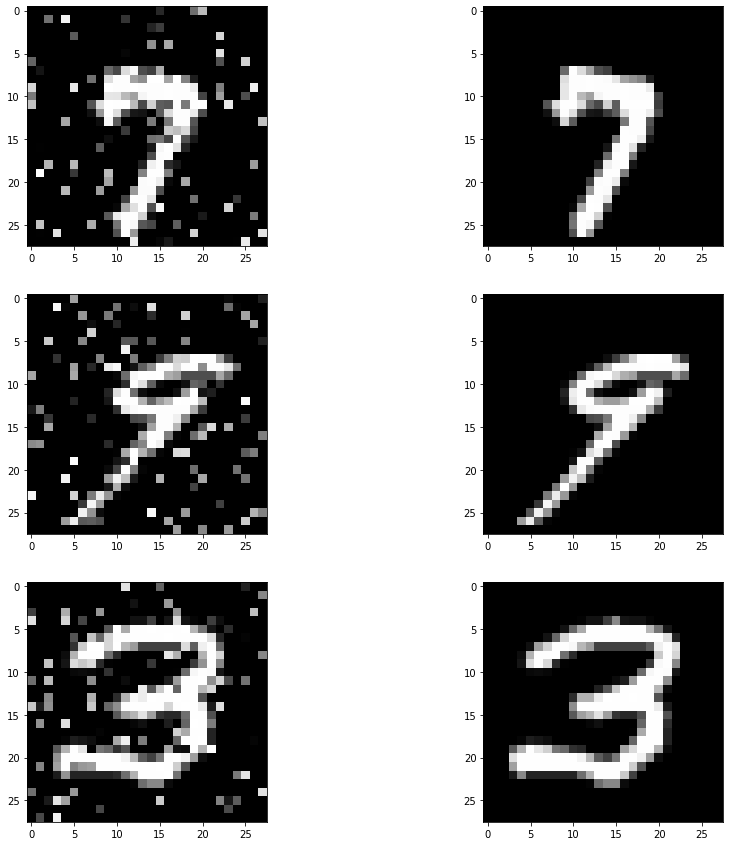

In [8]:
fig = plt.figure(figsize=(15,15))

for i in range(1, 6, 2):
    
    plt.subplot(3, 2, i)
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    
    plt.subplot(3, 2, i+1)
    plt.imshow(example_targets[i], cmap="gray", interpolation="none")

### Building the Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
# Note, how to output an image in CNN? A possible solution
# https://www.mathworks.com/matlabcentral/answers/458769-how-to-train-cnn-with-an-image-in-the-input-and-an-image-in-the-output#answer_495784
# https://phillipi.github.io/pix2pix/
# https://machinelearningmastery.com/a-gentle-introduction-to-pix2pix-generative-adversarial-network/
# https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        self.leakyRELU = nn.LeakyReLU(0.1)
        
        self.conv1 = nn.Conv2d(1, 100, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(150, 100, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(100, 50, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(50, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.leakyRELU(self.conv1(x))
        x = self.leakyRELU(self.conv2(x))
        x = self.leakyRELU(self.conv3(x))
        x = self.leakyRELU(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        return x

In [11]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)

### Training the Model

In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(1, n_epochs+1)]

In [13]:
# https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch
# https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/
def train(epoch):
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
              
        #plt.imshow(output[1][0].detach(), cmap="gray", interpolation="none")
        #plt.show()
        #set_trace()
        
        loss = F.mse_loss(torch.flatten(output, 0), torch.flatten(target, 0), reduction="mean")
        loss.backward()
        
        clipping_value = 2 # arbitrary value of your choosing
        torch.nn.utils.clip_grad_norm_(network.parameters(), clipping_value)
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({(100.0 * batch_idx / len(train_loader)):.0f}%)]\t Loss: {loss.item():.6f}")
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), "files/models/model2.pth")
            torch.save(optimizer.state_dict(), "files/models/optimizer2.pth")

In [14]:
# https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
def test():
    network.eval()
    
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
           
            test_loss += F.mse_loss(torch.flatten(output, 0), 
                                    torch.flatten(target, 0), 
                                    reduction="mean").item()
            
        test_loss /= len(test_loader.dataset) / batch_size_test
        test_losses.append(test_loss)
        print(f"\nTest set: Avg. loss: {test_loss:.4f}\n")              

In [15]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/42000 (0%)]	 Loss: 7437.131348
Train Epoch: 1 [640/42000 (2%)]	 Loss: 2554.541504
Train Epoch: 1 [1280/42000 (3%)]	 Loss: 1060.635376
Train Epoch: 1 [1920/42000 (5%)]	 Loss: 738.907715
Train Epoch: 1 [2560/42000 (6%)]	 Loss: 696.817261
Train Epoch: 1 [3200/42000 (8%)]	 Loss: 641.402649
Train Epoch: 1 [3840/42000 (9%)]	 Loss: 642.521973
Train Epoch: 1 [4480/42000 (11%)]	 Loss: 583.911011
Train Epoch: 1 [5120/42000 (12%)]	 Loss: 598.742615
Train Epoch: 1 [5760/42000 (14%)]	 Loss: 534.647949
Train Epoch: 1 [6400/42000 (15%)]	 Loss: 567.075317
Train Epoch: 1 [7040/42000 (17%)]	 Loss: 545.985718
Train Epoch: 1 [7680/42000 (18%)]	 Loss: 527.581421
Train Epoch: 1 [8320/42000 (20%)]	 Loss: 557.006775
Train Epoch: 1 [8960/42000 (21%)]	 Loss: 539.142395
Train Epoch: 1 [9600/42000 (23%)]	 Loss: 542.747070
Train Epoch: 1 [10240/42000 (24%)]	 Loss: 515.321533
Train Epoch: 1 [10880/42000 (26%)]	 Loss: 505.728729
Train Epoch: 1 [11520/42000 (27%)]	 Loss: 502.031464
Train Epoch: 1 [1

Train Epoch: 3 [14720/42000 (35%)]	 Loss: 280.241486
Train Epoch: 3 [15360/42000 (37%)]	 Loss: 304.303925
Train Epoch: 3 [16000/42000 (38%)]	 Loss: 296.125397
Train Epoch: 3 [16640/42000 (40%)]	 Loss: 299.832184
Train Epoch: 3 [17280/42000 (41%)]	 Loss: 312.982849
Train Epoch: 3 [17920/42000 (43%)]	 Loss: 291.167358
Train Epoch: 3 [18560/42000 (44%)]	 Loss: 272.960571
Train Epoch: 3 [19200/42000 (46%)]	 Loss: 292.546143
Train Epoch: 3 [19840/42000 (47%)]	 Loss: 312.467529
Train Epoch: 3 [20480/42000 (49%)]	 Loss: 285.508209
Train Epoch: 3 [21120/42000 (50%)]	 Loss: 291.533051
Train Epoch: 3 [21760/42000 (52%)]	 Loss: 310.436432
Train Epoch: 3 [22400/42000 (53%)]	 Loss: 301.275818
Train Epoch: 3 [23040/42000 (55%)]	 Loss: 303.452637
Train Epoch: 3 [23680/42000 (56%)]	 Loss: 272.623474
Train Epoch: 3 [24320/42000 (58%)]	 Loss: 303.650879
Train Epoch: 3 [24960/42000 (59%)]	 Loss: 286.332031
Train Epoch: 3 [25600/42000 (61%)]	 Loss: 314.152374
Train Epoch: 3 [26240/42000 (62%)]	 Loss: 284.

Train Epoch: 5 [29440/42000 (70%)]	 Loss: 242.168365
Train Epoch: 5 [30080/42000 (72%)]	 Loss: 261.686829
Train Epoch: 5 [30720/42000 (73%)]	 Loss: 253.626709
Train Epoch: 5 [31360/42000 (75%)]	 Loss: 269.273956
Train Epoch: 5 [32000/42000 (76%)]	 Loss: 259.254730
Train Epoch: 5 [32640/42000 (78%)]	 Loss: 231.663467
Train Epoch: 5 [33280/42000 (79%)]	 Loss: 230.801773
Train Epoch: 5 [33920/42000 (81%)]	 Loss: 252.367752
Train Epoch: 5 [34560/42000 (82%)]	 Loss: 256.433472
Train Epoch: 5 [35200/42000 (84%)]	 Loss: 259.271973
Train Epoch: 5 [35840/42000 (85%)]	 Loss: 257.346954
Train Epoch: 5 [36480/42000 (87%)]	 Loss: 253.200211
Train Epoch: 5 [37120/42000 (88%)]	 Loss: 230.383926
Train Epoch: 5 [37760/42000 (90%)]	 Loss: 259.115936
Train Epoch: 5 [38400/42000 (91%)]	 Loss: 262.436310
Train Epoch: 5 [39040/42000 (93%)]	 Loss: 245.870056
Train Epoch: 5 [39680/42000 (94%)]	 Loss: 249.586533
Train Epoch: 5 [40320/42000 (96%)]	 Loss: 250.525024
Train Epoch: 5 [40960/42000 (97%)]	 Loss: 222.

Train Epoch: 8 [1280/42000 (3%)]	 Loss: 223.416016
Train Epoch: 8 [1920/42000 (5%)]	 Loss: 235.749954
Train Epoch: 8 [2560/42000 (6%)]	 Loss: 232.982346
Train Epoch: 8 [3200/42000 (8%)]	 Loss: 220.084579
Train Epoch: 8 [3840/42000 (9%)]	 Loss: 226.291931
Train Epoch: 8 [4480/42000 (11%)]	 Loss: 232.025665
Train Epoch: 8 [5120/42000 (12%)]	 Loss: 236.452194
Train Epoch: 8 [5760/42000 (14%)]	 Loss: 252.217072
Train Epoch: 8 [6400/42000 (15%)]	 Loss: 222.706528
Train Epoch: 8 [7040/42000 (17%)]	 Loss: 246.213531
Train Epoch: 8 [7680/42000 (18%)]	 Loss: 231.864532
Train Epoch: 8 [8320/42000 (20%)]	 Loss: 236.718796
Train Epoch: 8 [8960/42000 (21%)]	 Loss: 252.904938
Train Epoch: 8 [9600/42000 (23%)]	 Loss: 230.646301
Train Epoch: 8 [10240/42000 (24%)]	 Loss: 239.201492
Train Epoch: 8 [10880/42000 (26%)]	 Loss: 215.944794
Train Epoch: 8 [11520/42000 (27%)]	 Loss: 217.811340
Train Epoch: 8 [12160/42000 (29%)]	 Loss: 227.408783
Train Epoch: 8 [12800/42000 (30%)]	 Loss: 209.392456
Train Epoch:

Train Epoch: 10 [16000/42000 (38%)]	 Loss: 224.310593
Train Epoch: 10 [16640/42000 (40%)]	 Loss: 214.553589
Train Epoch: 10 [17280/42000 (41%)]	 Loss: 206.862488
Train Epoch: 10 [17920/42000 (43%)]	 Loss: 207.207672
Train Epoch: 10 [18560/42000 (44%)]	 Loss: 204.796021
Train Epoch: 10 [19200/42000 (46%)]	 Loss: 218.614441
Train Epoch: 10 [19840/42000 (47%)]	 Loss: 224.924011
Train Epoch: 10 [20480/42000 (49%)]	 Loss: 215.009308
Train Epoch: 10 [21120/42000 (50%)]	 Loss: 211.283157
Train Epoch: 10 [21760/42000 (52%)]	 Loss: 213.760818
Train Epoch: 10 [22400/42000 (53%)]	 Loss: 214.647919
Train Epoch: 10 [23040/42000 (55%)]	 Loss: 218.259888
Train Epoch: 10 [23680/42000 (56%)]	 Loss: 213.918442
Train Epoch: 10 [24320/42000 (58%)]	 Loss: 208.293076
Train Epoch: 10 [24960/42000 (59%)]	 Loss: 230.042450
Train Epoch: 10 [25600/42000 (61%)]	 Loss: 211.490387
Train Epoch: 10 [26240/42000 (62%)]	 Loss: 216.563522
Train Epoch: 10 [26880/42000 (64%)]	 Loss: 205.268356
Train Epoch: 10 [27520/42000

Text(0, 0.5, 'MSE loss')

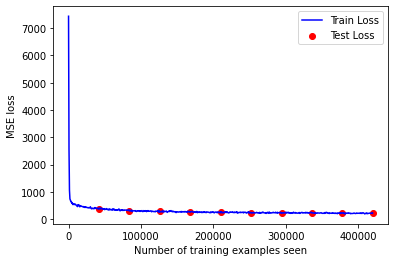

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color="blue")
plt.scatter(test_counter, test_losses, color="red")
plt.legend(["Train Loss", "Test Loss"], loc="upper right")
plt.xlabel("Number of training examples seen")
plt.ylabel("MSE loss")

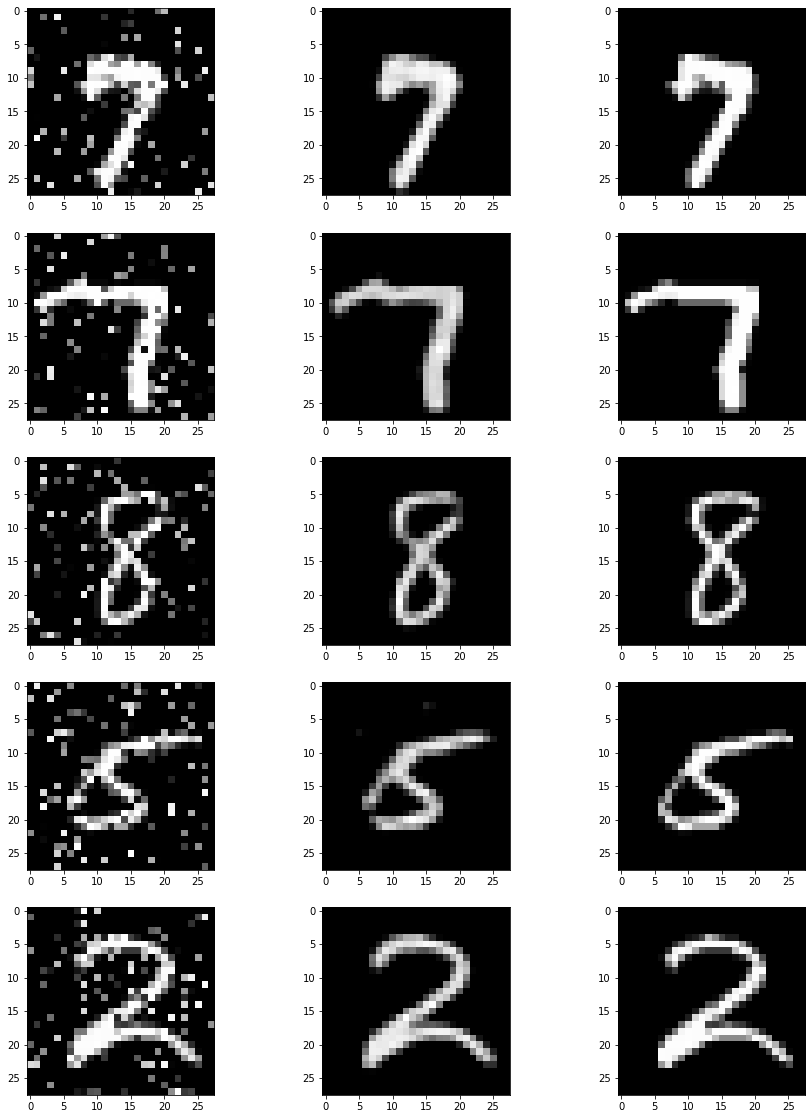

In [17]:
fig = plt.figure(figsize=(15,20))

with torch.no_grad():
    for i in range(1, 15, 3):

        output = network(example_data[i])

        plt.subplot(5, 3, i)
        plt.imshow(example_data[i][0], cmap="gray", interpolation="none")

        plt.subplot(5, 3, i+1)
        plt.imshow(output[0].detach(), cmap="gray", interpolation="none")

        plt.subplot(5, 3, i+2)
        plt.imshow(example_targets[i], cmap="gray", interpolation="none")